In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob as gb
import tensorflow as tf

2021-10-13 21:58:00.015651: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
size=94
train_dir='./images/'

train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.1,
).flow_from_directory(train_dir,batch_size=16,target_size=(size,size),subset="training",shuffle=True)


Found 12927 images belonging to 4 classes.


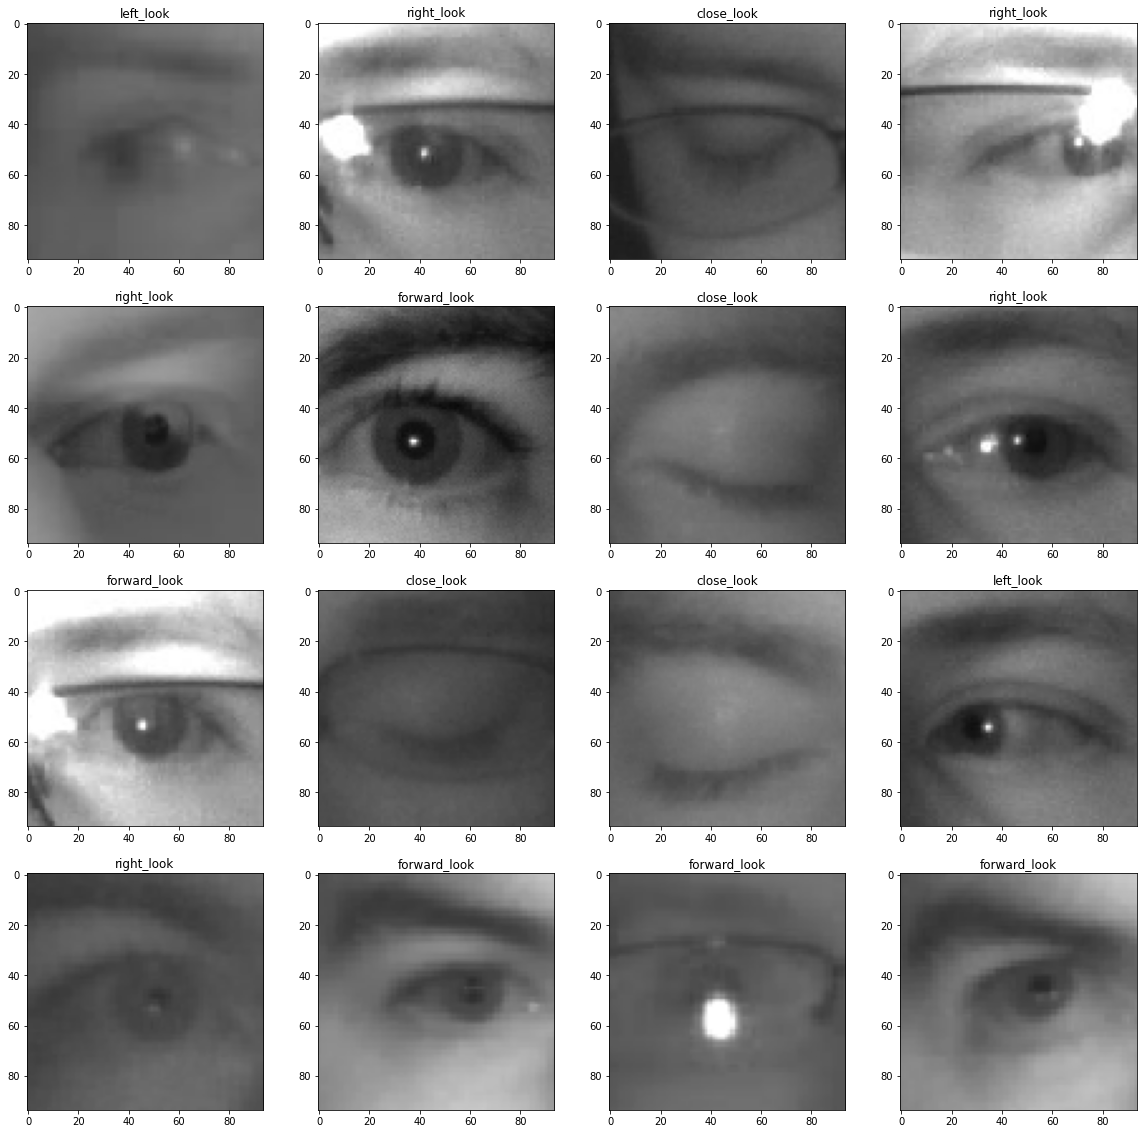

In [3]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [4]:
valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.1,
).flow_from_directory(train_dir,batch_size=16,target_size=(size,size),subset='validation',shuffle=True)


Found 1433 images belonging to 4 classes.


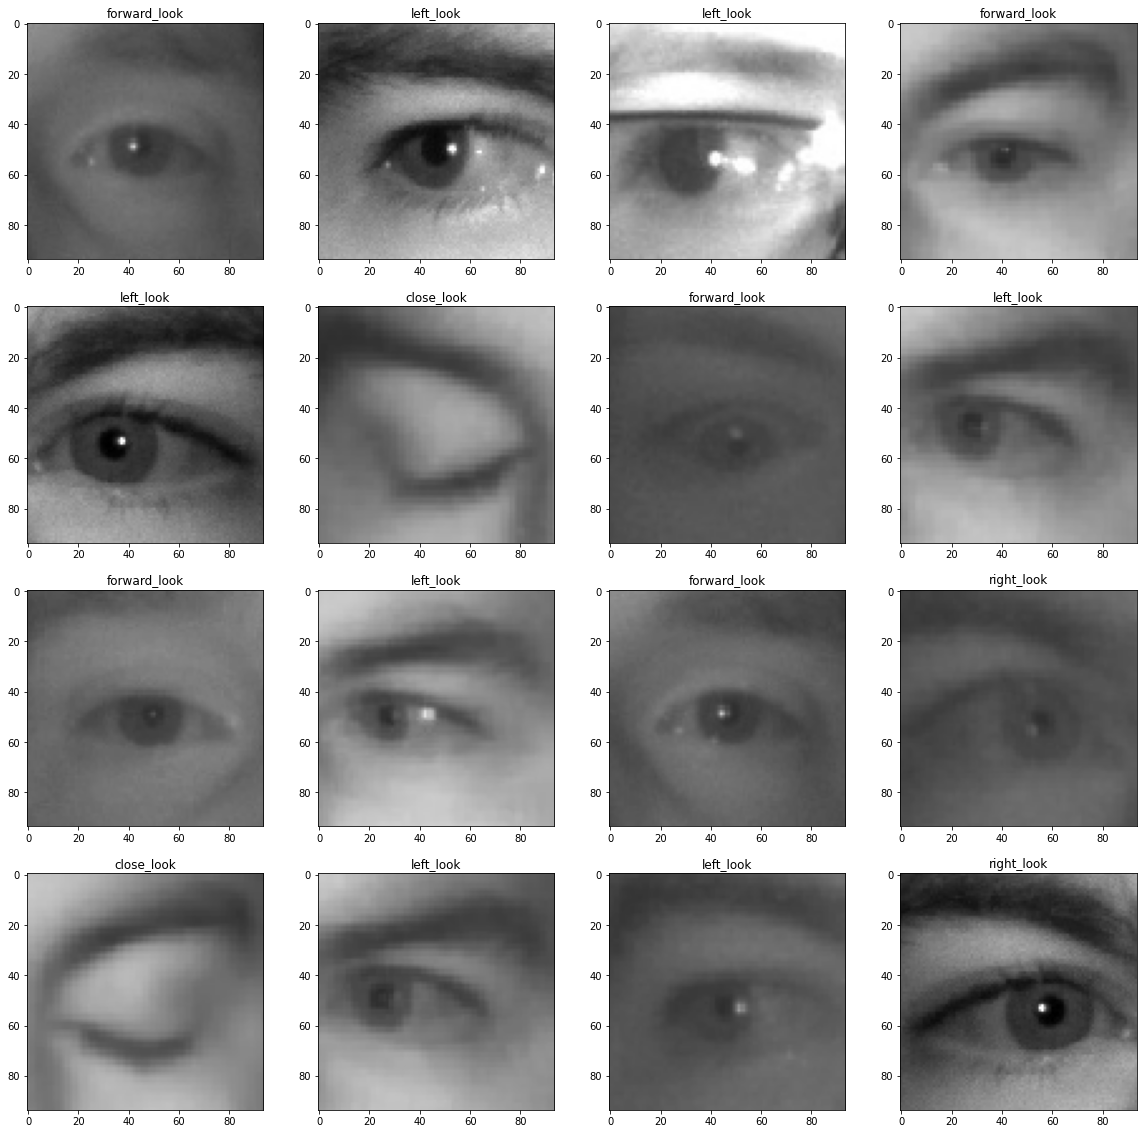

In [5]:
classes=list(valid_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in valid_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [6]:
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.1
).flow_from_directory(train_dir,batch_size=16,target_size=(size,size),subset='validation',shuffle=True)


Found 1433 images belonging to 4 classes.


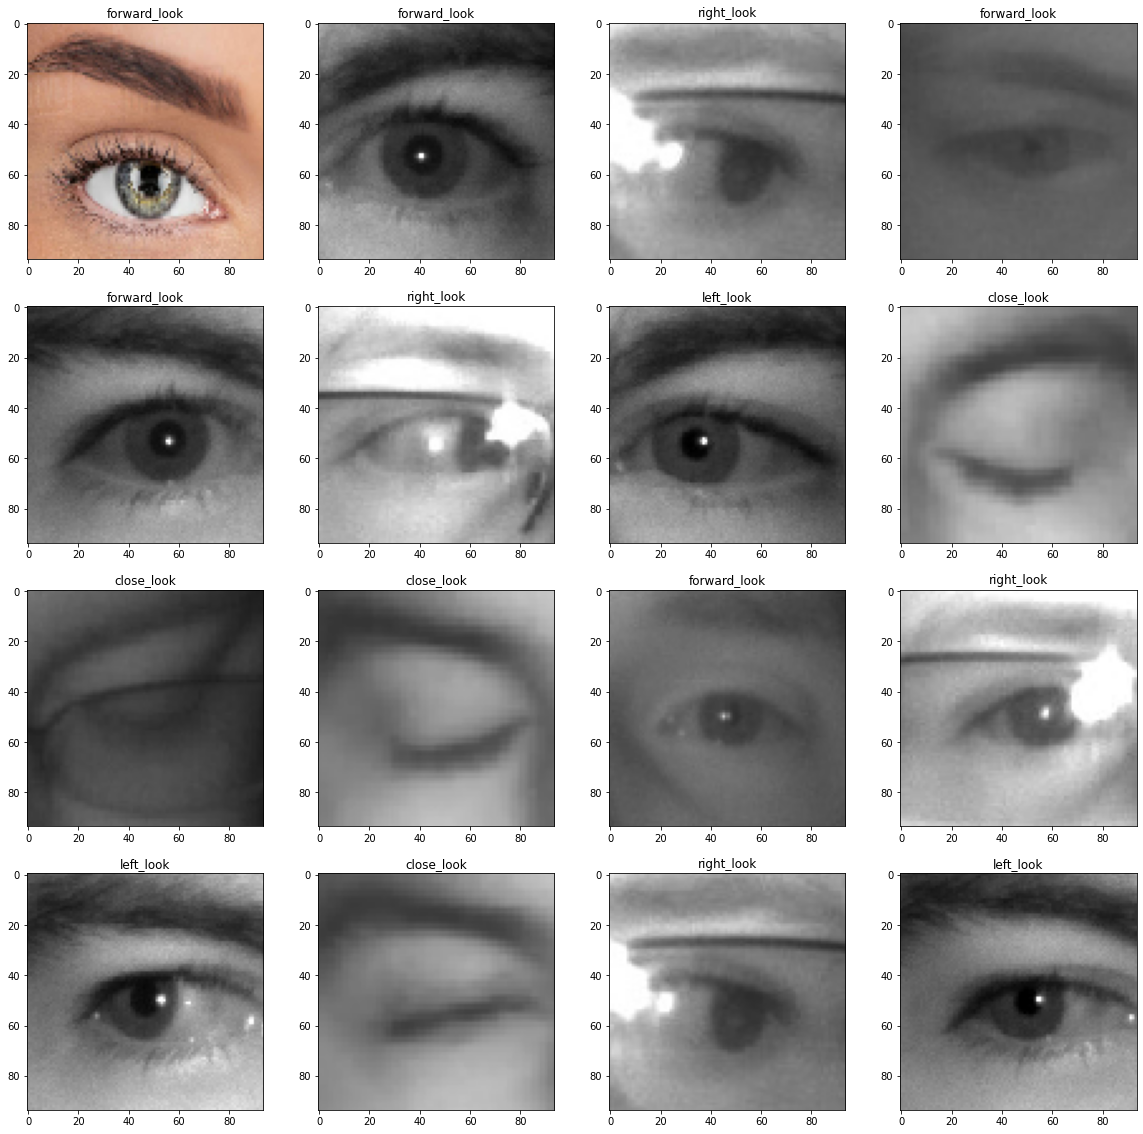

In [7]:
classes=list(test_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in test_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [8]:
classes

['close_look', 'forward_look', 'left_look', 'right_look']

In [9]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization ,GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

In [10]:
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [11]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [12]:
model=Sequential([
                  Conv2D(32,3,activation='relu',kernel_initializer='he_normal',input_shape=(size,size,3)),
                  Conv2D(64,3,activation='relu',kernel_initializer='he_normal'),
                  BatchNormalization(),
                  MaxPooling2D(3),
    
                  Conv2D(128,3,activation='relu',kernel_initializer='he_normal'),
                  BatchNormalization(),
                  MaxPooling2D(3),
    
                  Conv2D(256,3,activation='relu',kernel_initializer='he_normal'),
                  BatchNormalization(),
                  MaxPooling2D(3),
    
                  Flatten(),
                  Dense(64,activation='relu',kernel_initializer='he_normal'),
                  BatchNormalization(),
                  Dense(4,activation='softmax',kernel_initializer='glorot_normal')
                  
])


2021-10-13 21:58:16.536992: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-13 21:58:16.540490: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-13 21:58:16.578640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 21:58:16.579343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-13 21:58:16.579403: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-13 21:58:16.604522: I tensorflow/stream_executor/platform/def

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 92, 92, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 90, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 128)         0

In [14]:
model.compile(optimizer=optimizer_adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
history=model.fit(train_generator,validation_data=valid_generator,epochs=50,batch_size=16,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(valid_generator)//16,
                  callbacks=callback, verbose=1)

Epoch 1/50
50/50 [==============================] - 3s 58ms/step - loss: 0.2153 - accuracy: 0.9237 - val_loss: 0.3093 - val_accuracy: 0.9125

Epoch 00001: val_loss improved from 0.53884 to 0.30930, saving model to model.hdf5
Epoch 2/50
50/50 [==============================] - 3s 55ms/step - loss: 0.2004 - accuracy: 0.9362 - val_loss: 0.6825 - val_accuracy: 0.7875

Epoch 00002: val_loss did not improve from 0.30930
Epoch 3/50
50/50 [==============================] - 2s 49ms/step - loss: 0.1996 - accuracy: 0.9375 - val_loss: 0.3506 - val_accuracy: 0.9125

Epoch 00003: val_loss did not improve from 0.30930
Epoch 4/50
50/50 [==============================] - 2s 47ms/step - loss: 0.1686 - accuracy: 0.9450 - val_loss: 0.2414 - val_accuracy: 0.9375

Epoch 00004: val_loss improved from 0.30930 to 0.24140, saving model to model.hdf5
Epoch 5/50
50/50 [==============================] - 2s 45ms/step - loss: 0.1870 - accuracy: 0.9388 - val_loss: 0.5458 - val_accuracy: 0.8250

Epoch 00005: val_loss 

In [20]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

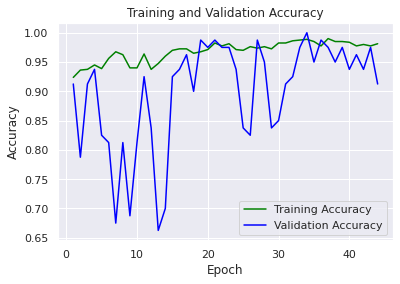

In [21]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


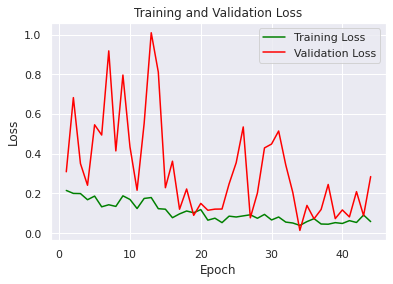

In [22]:
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

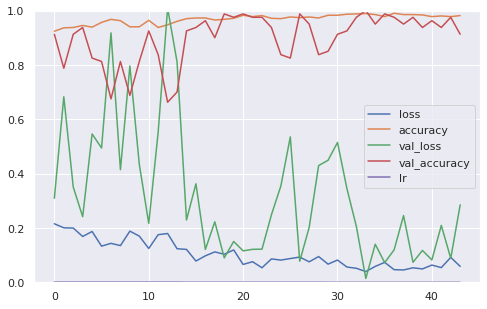

In [23]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()